# [07] Activation Map의 적용

`06`의 실습에서 `Activation Map의 시각화`를 구현해보았었습니다.

본 실습에서는 COVID Classification 학습했던 신경망을 바탕으로 실제 이미지를 한번 뽑아보겠습니다.

In [1]:
import copy
import os

import cv2
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms

from materials.mobilenetv2 import mobilenet_v2
from materials.grad_cam import (
    BackPropagation,
    Deconvnet,
    GradCAM,
    GuidedBackPropagation,
    occlusion_sensitivity,
)

In [2]:
def get_device(cuda):
    cuda = cuda and torch.cuda.is_available()
    device = torch.device("cuda" if cuda else "cpu")
    if cuda:
        current_device = torch.cuda.current_device()
        print("Device:", torch.cuda.get_device_name(current_device))
    else:
        print("Device: CPU")
    return device

In [3]:
device = get_device(cuda=True)

Device: TITAN RTX


## 데이터 셋 불러오기

In [4]:
TEST_DATA_PATH = './COVID19-DATASET/test/'

test_transforms = transforms.Compose([
                                      transforms.Resize((150,150)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


test_image = datasets.ImageFolder(TEST_DATA_PATH, transform=test_transforms)

testloader = torch.utils.data.DataLoader(test_image, batch_size=5)
class_names = testloader.dataset.classes

## 학습한 신경망 불러오기

In [5]:
model = mobilenet_v2(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

In [6]:
model.load_state_dict(torch.load('./best_model.pth', map_location='cpu'))
model.eval()
print('Inference Model Loaded on CPU')

Inference Model Loaded on CPU


신경망의 gradient False로 만들기

In [7]:
for params in model.parameters():
    params.requires_grad = False

In [8]:
dataiter = iter(testloader)
images, labels = dataiter.next()

std_correction = np.asarray([0.5, 0.5, 0.5]).reshape(3, 1, 1)

#define mean correction to be made
mean_correction = np.asarray([0.5, 0.5, 0.5]).reshape(3, 1, 1)

#convert the tensor img to numpy img and de normalize 
raw_images = np.multiply(images.numpy(), std_correction) + mean_correction
print(raw_images.shape)
raw_images = raw_images.transpose(0, 2,3,1)
print(raw_images.shape)
images = images.to(device)

(5, 3, 150, 150)
(5, 150, 150, 3)


# Backpropagation
- 단순히 image에 대한 gradient들을 image로 저장합니다

Q) gradient는 어떻게 뽑아내는 것이 좋을까요?

Q) 이미지로 저장할 때는 어떻게 하는 것이 좋을까요?

In [9]:
def show_gradient(gradient):
    gradient = ????????
    gradient -= ????????
    gradient /= ???????
    #gradient *= 255.0
    
    plt.imshow(np.array(gradient))
    
    #filename을 지정하면 저장도 할 수 있다.
    #cv2.imwrite(filename, np.uint8(gradient))

앞서 만들어본 클래스를 불러와서 이미지를 만들어봅니다.

In [10]:
def get_backprop(model, images, classes, model_name):
    # name: {}-{}-backprop-{}.png
    bp = BackPropagation(model=model)
    probs, ids = bp.forward(images)  # sorted
    
    # i는 top1값만 할 것인지를 의미.
    for i in range(1):
        bp.backward(ids=ids[:, [i]])
        gradients = bp.generate()
        print(gradients.shape)
        # Save results as image files
        for j in range(len(images)):
            print("\t#{}: {} ({:.5f})".format(j, classes[ids[j, i]], probs[j, i]))
            plt.figure()
            show_gradient(gradient=gradients[j])

    # Remove all the hook function in the "model"
    bp.remove_hook()

torch.Size([5, 3, 150, 150])
	#0: covid19 (1.00000)
	#1: covid19 (1.00000)
	#2: covid19 (0.99712)
	#3: covid19 (0.99879)
	#4: covid19 (0.99997)


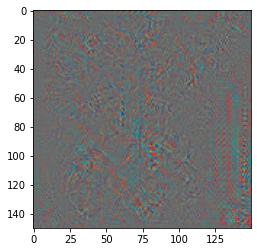

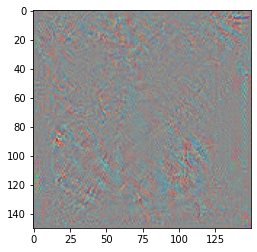

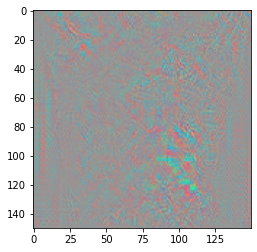

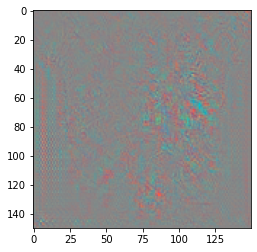

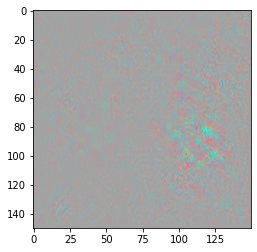

In [11]:
get_backprop(model, images, class_names, 'mobilenetv2')

## GradCAM

GradCAM을 위한 코드를 재구성해봅니다.

In [12]:
def show_gradcam(gcam, raw_image, paper_cmap=False):
    gcam = gcam.cpu().numpy()
    cmap = cm.jet_r(gcam)[..., :3] * 255.0
    if paper_cmap:
        alpha = gcam[..., None]
        gcam = alpha * cmap + (1 - alpha) * raw_image * 255
    else:
        gcam = (cmap.astype(np.float) + raw_image.astype(np.float) * 255) / 2
    plt.imshow(gcam/255)
    #마찬가지로, filename을 지정하면 파일을 저장할 수 있다.
    #cv2.imwrite(filename, np.uint8(gcam))

In [13]:
def guided_grad(model, images, classes, model_name):

    gbp = GuidedBackPropagation(model=model)
    probs, ids = gbp.forward(images)

    for i in range(1):
        # Guided Backpropagation
        gbp.backward(ids=ids[:, [i]])
        gradients = gbp.generate()


        for j in range(len(images)):
            print("\t#{}: {} ({:.5f})".format(j, classes[ids[j, i]], probs[j, i]))

            # Guided Backpropagation
            plt.figure()
            show_gradient(gradient=gradients[j])

In [14]:
def gradCAM(model, images, classes, model_name):

    gcam = GradCAM(model=model)
    probs, ids = gcam.forward(images)

    for i in range(1):
        # Grad-CAM
        gcam.backward(ids=ids[:, [i]])
        regions = gcam.generate(target_layer='features')

        for j in range(len(images)):
            print("\t#{}: {} ({:.5f})".format(j, classes[ids[j, i]], probs[j, i]))

            # Grad-CAM
            plt.figure()
            show_gradcam(gcam=regions[j, 0], raw_image=raw_images[j])

In [15]:
def guided_gradCAM(model, images, classes, model_name):

    gcam = GradCAM(model=model)
    probs, ids = gcam.forward(images)

    gbp = GuidedBackPropagation(model=model)
    _ = gbp.forward(images)

    for i in range(1):
        # Guided Backpropagation
        gbp.backward(ids=ids[:, [i]])
        gradients = gbp.generate()

        # Grad-CAM
        gcam.backward(ids=ids[:, [i]])
        regions = gcam.generate(target_layer='features')

        for j in range(len(images)):
            print("\t#{}: {} ({:.5f})".format(j, classes[ids[j, i]], probs[j, i]))

            # Guided Grad-CAM
            plt.figure()
            show_gradient(gradient=torch.mul(regions, gradients)[j])

	#0: covid19 (1.00000)
	#1: covid19 (1.00000)
	#2: covid19 (0.99712)
	#3: covid19 (0.99879)
	#4: covid19 (0.99997)


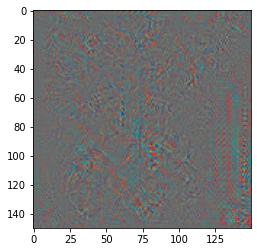

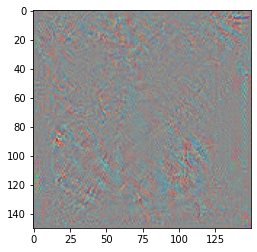

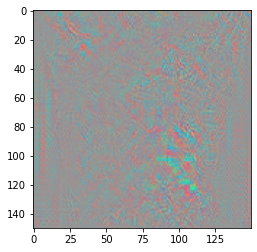

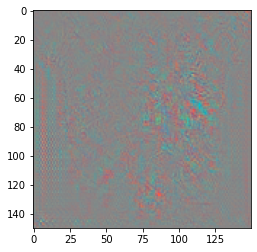

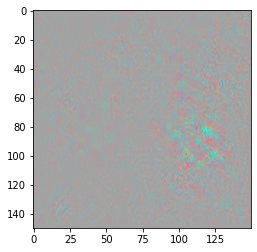

In [16]:
guided_grad(model, images, class_names, 'mobilenetv2')

	#0: covid19 (1.00000)
	#1: covid19 (1.00000)
	#2: covid19 (0.99712)
	#3: covid19 (0.99879)
	#4: covid19 (0.99997)


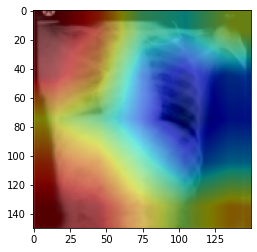

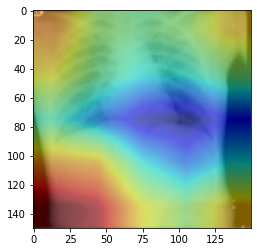

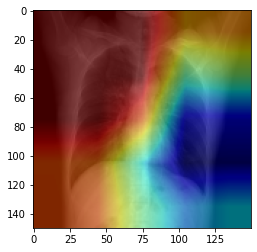

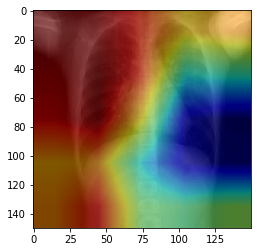

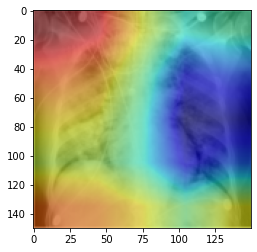

In [17]:
gradCAM(model, images, class_names, 'mobilenetv2')

	#0: covid19 (1.00000)
	#1: covid19 (1.00000)
	#2: covid19 (0.99712)
	#3: covid19 (0.99879)
	#4: covid19 (0.99997)


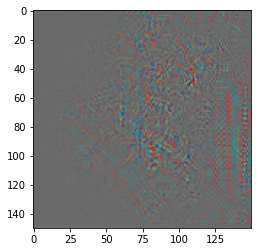

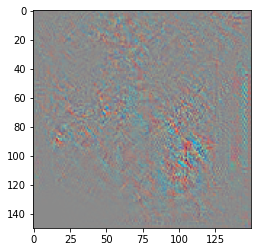

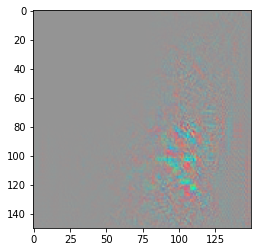

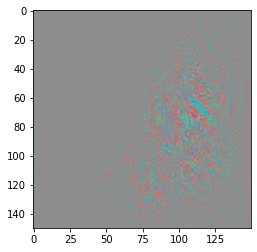

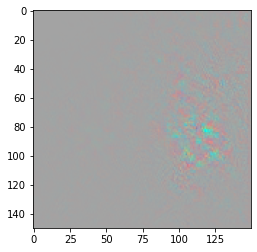

In [18]:
guided_gradCAM(model, images, class_names, 'mobilenetv2')

---------
### <생각해 봅시다>

- Grad-CAM, guided Grad-CAM, backprop 등의 방법론은 잘 시각화 되었나요?
- 이것을 더 improve하기 위해서 우리는 무엇을 더 해보는 것이 좋을까요?
- 고민해보고 시도해보세요.

------------